In [1]:
# Imports
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sn

# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.stats.anova import anova_lm
# from numpy import *
# import scipy as sp
# from pandas import *

from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas.rpy.common as com

from math import *
import os,glob,sys,platform

from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

import pickle as pickle
import pandas as pd

from IPython import embed

from BehaviorAnalyzer import BehaviorAnalyzer
from PupilAnalyzer import PupilAnalyzer
from Plotter import Plotter


from analysis_parameters import *

/home/barendregt/programs/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html


In [2]:
def fitcdf(x,s):
	return sp.stats.norm.cdf(x,0,s)

def estimate_auc(X,Y, niter = 1000):

	y = label_binarize(Y, classes=[0, 1])
	x = X[:,np.newaxis]

	# shuffle and split training and test sets
	roc_auc = np.zeros((niter,1))
	for i in range(niter):
		X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.5)

		# Learn to predict each class against the other
		classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
		y_score = classifier.fit(X_train, y_train).decision_function(X_test)

		# Compute ROC curve and ROC area for each class
		fpr, tpr, _ = roc_curve(y_test, y_score)
		roc_auc[i] = auc(fpr, tpr)	

	return roc_auc.mean()

In [3]:
# VARIABLES

pl = Plotter(figure_folder = figfolder, linestylemap = linestylemap)

condition_keymap = { 0: 'PP',  1: 'PP',
					10: 'PU', 20: 'PU',
					30: 'UU', 40: 'UU',
					50: 'UP', 60: 'UP'}

inverse_keymap = {'PP': [0,1],
				  'UU': [30,40],
				  'PU': [10,20],
				  'UP': [50,60]}

choice_prob = {'UP': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*(deconv_sample_frequency))),dtype=float),
			   'PU': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*(deconv_sample_frequency))),dtype=float)}	 

all_pupil_correct = {'UP': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*(deconv_sample_frequency))),dtype=float),
					 'PU': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*(deconv_sample_frequency))),dtype=float)}

all_pupil_incorrect = {'UP': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*(deconv_sample_frequency))),dtype=float),
					   'PU': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*(deconv_sample_frequency))),dtype=float)}


In [4]:
# MAIN LOOP

for subname in sublist:

	# Organize filenames
	rawfolder = os.path.join(raw_data_folder,subname)
	sharedfolder = os.path.join(shared_data_folder,subname)
	csvfilename = glob.glob(rawfolder + '/*.csv')#[-1]
	h5filename = os.path.join(sharedfolder,subname+'.h5')

	# Initialize PA object
	pa = PupilAnalyzer(subname, h5filename, rawfolder, reference_phase = 7, signal_downsample_factor = down_fs, signal_sample_frequency = signal_sample_frequency, deconv_sample_frequency = deconv_sample_frequency, deconvolution_interval = stimulus_deconvolution_interval, verbosity = 0)


	# Combine signals based on condition	

	sub_signals = {'correct': {'PP': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*signal_sample_frequency)),dtype=float),
								 'UP': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*signal_sample_frequency)),dtype=float),
								 'PU': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*signal_sample_frequency)),dtype=float),
								 'UU': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*signal_sample_frequency)),dtype=float)},
								 'incorrect': {'PP': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*signal_sample_frequency)),dtype=float),
								 'UP': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*signal_sample_frequency)),dtype=float),
								 'PU': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*signal_sample_frequency)),dtype=float),
								 'UU': np.empty((0,int((stimulus_deconvolution_interval[1] - stimulus_deconvolution_interval[0])*signal_sample_frequency)),dtype=float)}}		 


	sub_rts = {'correct': {'PP': [],
					 'UP': [],
					 'PU': [],
					 'UU': []},
					 'incorrect': {'PP': [],
					 'UP': [],
					 'PU': [],
					 'UU': []}}	

	# Get trial-based, event-related, baseline-corrected signals centered on stimulus onset
	pa.signal_per_trial(only_correct = True, only_incorrect = False, return_dt=False, reference_phase = 7, with_rt = False, baseline_type = 'relative', baseline_period = [-.5, 0.0], force_rebuild=False, down_sample = False, return_rt = True)

	for (key,signals) in pa.trial_signals.items():
		if len(signals)>0:
			sub_signals['correct'][condition_keymap[key]] = np.append(sub_signals['correct'][condition_keymap[key]], signals, axis=0)

	# Get trial-based, event-related, baseline-corrected signals centered on stimulus onset
	pa.signal_per_trial(only_correct = False, only_incorrect = True, return_dt=False, reference_phase = 7, with_rt = False, baseline_type = 'relative', baseline_period = [-.5, 0.0], force_rebuild=False, down_sample = False, return_rt = True)

	for (key,signals) in pa.trial_signals.items():
		if len(signals)>0:
			sub_signals['incorrect'][condition_keymap[key]] = np.append(sub_signals['incorrect'][condition_keymap[key]], signals, axis=0)


	base_correct = sp.signal.decimate(sub_signals['correct']['PP'],down_fs,1)
	base_incorrect = sp.signal.decimate(sub_signals['incorrect']['PP'],down_fs,1)

	pupil_correct = {'UP': sp.signal.decimate(sub_signals['correct']['UP'],down_fs,1),
					 'PU': sp.signal.decimate(sub_signals['correct']['PU'],down_fs,1)}

	pupil_incorrect = {'UP': sp.signal.decimate(sub_signals['incorrect']['UP'],down_fs,1),
					   'PU': sp.signal.decimate(sub_signals['incorrect']['PU'],down_fs,1)}


	pupil_correct_nobase = {'UP': sp.signal.decimate(sub_signals['correct']['UP'],down_fs,1) - base_correct.mean(axis=0),
					 'PU': sp.signal.decimate(sub_signals['correct']['PU'],down_fs,1) - base_correct.mean(axis=0)}

	pupil_incorrect_nobase = {'UP': sp.signal.decimate(sub_signals['incorrect']['UP'],down_fs,1) - base_incorrect.mean(axis=0),
					   'PU': sp.signal.decimate(sub_signals['incorrect']['PU'],down_fs,1) - base_incorrect.mean(axis=0)}


	pupil_correct_dt = {}					   
	pupil_incorrect_dt = {}

	pupil_correct_dt['UP'] = np.diff(pupil_correct_nobase['UP'])
	pupil_incorrect_dt['UP'] = np.diff(pupil_incorrect_nobase['UP'])
	pupil_correct_dt['PU'] = np.diff(pupil_correct_nobase['PU'])
	pupil_incorrect_dt['PU'] = np.diff(pupil_incorrect_nobase['PU'])    

	
	sub_choice_prob = {'UP': np.zeros((pupil_correct['UP'].shape[1])), 
					   'PU': np.zeros((pupil_correct['PU'].shape[1]))}

	for key in list(choice_prob.keys()):
		for t in range(0,pupil_correct_nobase[key].shape[1]):	
			t0_correct = pupil_correct_nobase[key][:,t]
			t0_incorrect = pupil_incorrect_nobase[key][:,t]

			pdata = np.hstack([t0_correct, t0_incorrect])
			cdata = np.hstack([np.ones((t0_correct.shape[0],)), np.zeros((t0_incorrect.shape[0],))])

			#sub_choice_prob[key][t] = estimate_auc(pdata, cdata, niter=100)

			#cdf_param = sp.optimize.curve_fit(fitcdf, pdata, cdata, p0=[.5])[0]

			fpr, tpr, _ = roc_curve(cdata, pdata)#sp.stats.norm.cdf(pdata,0,cdf_param))
			sub_choice_prob[key][t] = auc(fpr, tpr)

	
		choice_prob[key] = np.append(choice_prob[key], sub_choice_prob[key][np.newaxis,:], axis=0)

/home/barendregt/programs/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:3073: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


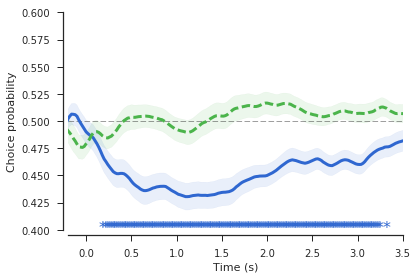

In [10]:
# PLOT STUFF

smooth_factor = 10# deconv_sample_frequency

# embed()

pl.open_figure(force=1)

# pl.subplot(1,2,1)

pl.hline(0.5)
#pl.event_related_pupil_average(choice_prob,conditions=['UP'],signal_labels={'UP':'TaskRel/dt'},x_lim=[80,200],xticks=[100,110,120,130,140,150,200,250],xticklabels=[0,.1,.2,.3,.4,.5,1,1.5], compute_mean=True,compute_sd=True,show_legend=True, ylabel='Choice probability', y_lim=[0.4,0.6], with_stats=True, stats_ttest_ref=0.5, sig_marker_ypos = 0.41, after_smooth=True, after_smooth_factor = 50)
pl.event_related_pupil_average(choice_prob,conditions=['UP','PU'],signal_labels=keymap_to_words,
                              x_lim=[0.8*50,4.5*50],xticks=np.arange(0.5*50,5.0*50,0.5*50),xticklabels=np.arange(-0.5,4.5,0.5),
                              ylabel='Choice probability', y_lim=[0.4,0.6], 
                              with_stats=True, stats_ttest_ref=0.5, stats_ttest_p = 0.2, sig_marker_ypos = 0.41, compute_mean=True, compute_sd =True, mark_first_sig = False,
                              smooth_signal=False, smooth_factor=smooth_factor,
                              after_smooth=True,after_smooth_window=11)
# pl.vline(107, label='70ms', linestyle='solid')
pl.show()
pl.save_figure(filename='choice_probs_smooth.pdf', sub_folder='over_subs')